In [14]:
from trainer import *
import cv2

with open('configs/test_config.yaml') as file:
    config = yaml.full_load(file)
 
trainer = Trainer(config)

Saving checkpoint..
Initializing samples..


In [2]:
dataset = trainer.dataset
batch   = next(iter(trainer.train_loader))

# Create a sample

In [3]:
tgt_img  = batch['tgt'].to(trainer.device)         # [b, 3, H, W]
ref_imgs = [img.to(trainer.device) for img in batch['ref_imgs']]    # [[b, 3, H, W], [b, 3, H, W]]
K        = batch['intrinsics'].to(trainer.device)  # [b, 3, 4]
depth    = batch['groundtruth'].to(trainer.device) # [b, H, W]

In [4]:
pose = [oxts.to(trainer.device) for oxts in batch['oxts']]

In [5]:
K

tensor([[[0.9592, 0.0000, 0.6944],
         [0.0000, 0.9529, 0.2417],
         [0.0000, 0.0000, 0.0010]],

        [[0.9601, 0.0000, 0.6948],
         [0.0000, 0.9549, 0.2404],
         [0.0000, 0.0000, 0.0010]],

        [[0.9569, 0.0000, 0.6940],
         [0.0000, 0.9522, 0.2386],
         [0.0000, 0.0000, 0.0010]],

        [[0.9601, 0.0000, 0.6948],
         [0.0000, 0.9549, 0.2404],
         [0.0000, 0.0000, 0.0010]]], device='cuda:0', dtype=torch.float64)

# Compare Wraps

In [8]:
sample = dataset.__getitem__(100)

In [50]:
tgt        = np.transpose((sample['tgt'].cpu().detach().numpy() * 0.5) + 0.5, (1, 2, 0))
ref_imgs   = [np.transpose(0.5 + (img.cpu().detach().numpy() * 0.5), (1, 2, 0)) for img in sample['ref_imgs']]
gt         = sample['groundtruth']

projected_img = cv2.cvtColor(cv2.imread('./images/warping/198.png'), cv2.COLOR_BGR2RGB) / 255

In [56]:
print((tgt - projected_img).mean())
print((ref_imgs[0] - projected_img).mean())
print((ref_imgs[1] - projected_img).mean())

0.006990269541690233
0.0007531999255450671
0.011827625895157476


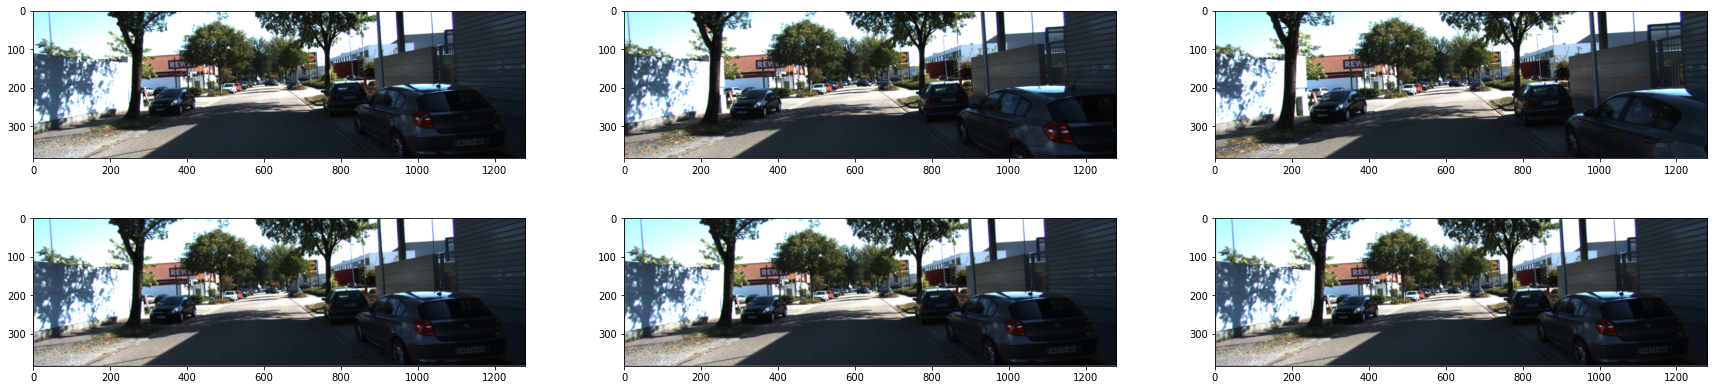

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(30,7))
axs[0, 0].imshow(ref_imgs[0])
axs[0, 1].imshow(tgt)
axs[0, 2].imshow(ref_imgs[1])
axs[1, 0].imshow(projected_img)
axs[1, 1].imshow(projected_img)
axs[1, 2].imshow(projected_img)

# Current Inverse Warp

In [ ]:
from geometry.pose_geometry import *
from geometry.transform import *

In [ ]:
projected_imgs = [inverse_warp(ref_img, depth, pose, K) for ref_img, pose in zip(ref_imgs, pose)]

In [ ]:
384 * 1280

In [ ]:
K

In [ ]:
# plot
proj_img = projected_imgs[0][0]
proj_img = 0.5 + (proj_img * 0.5)
proj_img = np.transpose((proj_img.squeeze()).cpu().detach().numpy(), (1, 2, 0))
GT = depth[0].squeeze().cpu().detach().numpy()

plt.imshow(proj_img)

# The Inverse Warp

The goal is to create a target image by transforming source images. But to get around splatting, we have to:

1. Transform target to source
2. As transformed pixels are continuous, use bilinear sampling (differentiable) to sample from source images.
3. As we know which pixel in target corresponds to which "transformed-and-sampled" source image we can create a target image.

### Resources
- [X] https://www.youtube.com/watch?v=lNYhWBPEeaY&list=PLyqSpQzTE6M-T5ZrthkU763MHKIKCa0sX&index=7
- [X] https://github.com/nianticlabs/monodepth2/issues/87
- [ ] https://www.cse.huji.ac.il/course/2006/impr/lectures2006/Tirgul8_LK.pdf

In [ ]:
def meshgrid(B, H, W, dtype, device, normalized=False):
    """
    Create meshgrid with a specific resolution
    Parameters
    ----------
    B : int
        Batch size
    H : int
        Height size
    W : int
        Width size
    dtype : torch.dtype
        Meshgrid type
    device : torch.device
        Meshgrid device
    normalized : bool
        True if grid is normalized between -1 and 1
    Returns
    -------
    xs : torch.Tensor [B,1,W]
        Meshgrid in dimension x
    ys : torch.Tensor [B,H,1]
        Meshgrid in dimension y
    """
    if normalized:
        xs = torch.linspace(-1, 1, W, device=device, dtype=dtype)
        ys = torch.linspace(-1, 1, H, device=device, dtype=dtype)
    else:
        xs = torch.linspace(0, W-1, W, device=device, dtype=dtype)
        ys = torch.linspace(0, H-1, H, device=device, dtype=dtype)
    ys, xs = torch.meshgrid([ys, xs])
    return xs.repeat([B, 1, 1]), ys.repeat([B, 1, 1])

def image_grid(B, H, W, dtype, device, normalized=False):
    """
    Create an image grid with a specific resolution
    Parameters
    ----------
    B : int
        Batch size
    H : int
        Height size
    W : int
        Width size
    dtype : torch.dtype
        Meshgrid type
    device : torch.device
        Meshgrid device
    normalized : bool
        True if grid is normalized between -1 and 1
    Returns
    -------
    grid : torch.Tensor [B,3,H,W]
        Image grid containing a meshgrid in x, y and 1
    """
    xs, ys = meshgrid(B, H, W, dtype, device, normalized=normalized)
    ones = torch.ones_like(xs)
    grid = torch.stack([xs, ys, ones], dim=1)
    return grid

def reconstruct(depth, K, frame='c'):
        """
        Reconstructs pixel-wise 3D points from a depth map.
        Parameters
        ----------
        depth : torch.Tensor [B,1,H,W]
            Depth map for the camera
        frame : 'w'
            Reference frame: 'c' for camera and 'w' for world
        Returns
        -------
        points : torch.tensor [B,3,H,W]
            Pixel-wise 3D points
        """
        depth = depth.unsqueeze(1)
        B, C, H, W = depth.shape
        assert C == 1
        
        Kinv = K.inverse().float()
        
        # Create flat index grid
        grid = image_grid(B, H, W, depth.dtype, depth.device, normalized=False)  # [B,3,H,W]
        flat_grid = grid.view(B, 3, -1)  # [B,3,HW]

        # Estimate the outward rays in the camera frame
        xnorm = (Kinv.bmm(flat_grid)).view(B, 3, H, W)
        # Scale rays to metric depth
        Xc = xnorm * depth

        # If in camera frame of reference
        if frame == 'c':
            return Xc
        # If in world frame of reference
        elif frame == 'w':
            return self.Twc @ Xc
        # If none of the above
        else:
            raise ValueError('Unknown reference frame {}'.format(frame))
            

In [ ]:
def project_cam_to_img(cam_coords, proj_c2p_rot, proj_c2p_tr):
    b, _, h, w = cam_coords.size()
    cam_coords_flat = cam_coords.reshape(b, 3, -1)  # [B, 3, H*W]
    if proj_c2p_rot is not None:
        pcoords = proj_c2p_rot @ cam_coords_flat
    else:
        pcoords = cam_coords_flat

    if proj_c2p_tr is not None:
        pcoords = pcoords + proj_c2p_tr  # [B, 3, H*W]

    X = pcoords[:, 0]
    Y = pcoords[:, 1]
    Z = pcoords[:, 2].clamp(min=1e-3)

    X_norm = 2*(X / Z)/(w-1) - 1  # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
    Y_norm = 2*(Y / Z)/(h-1) - 1  # Idem [B, H*W]

    pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
    return pixel_coords.reshape(b, h, w, 2)

In [ ]:
K=K*0.001

In [ ]:

cam_coords = reconstruct(depth, K) 

In [ ]:
pose_mat = pose_vec2mat(pose[0])  # [B,3,4]

# Get projection matrix for tgt camera frame to source pixel frame
proj_cam_to_src_pixel = K @ pose_mat  # [B, 3, 4]

rot, tr = proj_cam_to_src_pixel[..., :3], proj_cam_to_src_pixel[..., -1:]
src_pixel_coords = project_cam_to_img(cam_coords, rot.float(), tr.float())  # [B,H,W,2]

In [ ]:
p_img = F.grid_sample(ref_imgs[0], src_pixel_coords, mode='bilinear', padding_mode='zeros', align_corners=True)


In [ ]:
# plot
p_img = p_img[0]
p_img = 0.5 + (p_img * 0.5)
p_img = np.transpose((p_img.squeeze()).cpu().detach().numpy(), (1, 2, 0))
GT = depth[0].squeeze().cpu().detach().numpy()

plt.imshow(proj_img)

# Inference

In [86]:
from os import sep
from trainer import *
from models.depth.disp_net import DispNetS

from utils.transforms import UnNormalize
from geometry.pose_geometry import *

# load checkpoint
save_path = './pretrained/generic_sfm.pth'
checkpoint = torch.load(save_path)
depth_model_state_dict = checkpoint['dpth_mdl_state_dict']
pose_model_state_dict  = checkpoint['pose_mdl_state_dict']

# init dataset
with open('configs/test_config.yaml') as file:
    config = yaml.full_load(file)

trainer    = Trainer(config)
dataloader = trainer.train_loader

Loading Pretrained model..
Initializing samples..


In [87]:
one_sample = trainer.dataset.__getitem__(100)

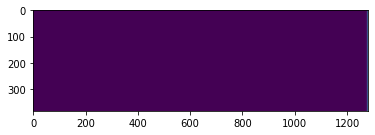

array([[0.07884064, 0.06116617, 0.05609491, ..., 0.22003822, 0.3682562 ,
        1.2595952 ],
       [0.06135485, 0.05855875, 0.05623516, ..., 0.22080074, 0.3631992 ,
        1.0651171 ],
       [0.05689953, 0.05648427, 0.05630302, ..., 0.22229291, 0.360304  ,
        0.9332609 ],
       ...,
       [0.05789136, 0.05760013, 0.05730964, ..., 0.24035971, 0.39733595,
        1.1510496 ],
       [0.07047061, 0.0580175 , 0.05763593, ..., 0.24308647, 0.40643957,
        1.2605932 ],
       [0.11075813, 0.05911456, 0.05817398, ..., 0.24638608, 0.41637576,
        1.5986886 ]], dtype=float32)

In [91]:
# load a depth model
depth_model = trainer.depth_model
depth_model.load_state_dict(depth_model_state_dict)
depth_model.eval()

# # load a pose model
# pose_model = trainer.pose_model
# pose_model.load_state_dict(pose_model_state_dict)
# pose_model.eval()

# test input image
input_imgs = one_sample['tgt'].unsqueeze(0).to(trainer.device)
ref_imgs   = [img.unsqueeze(0).to(trainer.device) for img in one_sample['ref_imgs']]

with torch.no_grad():
    # test and plot
    depth = depth_model(input_imgs)
#     pose  = pose_model(input_imgs, ref_imgs)

# split poses
# poses_t_0 = pose[:, 0, :]

# figure out all outputs
img        = (depth[0][0].squeeze()).cpu().detach().numpy()

plt.imshow(img)
plt.show()

img